

```
# This is formatted as code
```

# Object detection and segmentation
In this exercise you will learn about Fully convolutional networks, which are fundamental for semantic segmentation.

We will do some toy-samples using MNIST, but since we don't have any small semantic-annotated dataset, the core of this exercise is to understand the concepts, rather than creating perfect outputs.

After solving this, you can move on and try bigger models like FCN-8s, u-net, DeepLabv3 etc.


In [ ]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

import torch
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, MaxPool2d
from torch.nn.functional import relu, softmax

## 1. Import MNIST dataset

In [ ]:
from mlxtend.data import mnist_data
import numpy as np
import random
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

def splitdata(X, y, Ngroups, weights=None):
    '''
    X, y = input data and labels
    Ngroups = number of groups to split data into
    weights = a list with Ngroups weights, that tell the probability of a sample ending in either of the data sets
    '''
    if weights is None:
        weights = [1/Ngroups]*Ngroups

    groups = np.array(random.choices(list(range(Ngroups)), weights=weights, cum_weights=None, k=len(X)))
    return ((X[np.where(groups==g)], y[np.where(groups==g)]) for g in np.array(range(Ngroups)))



X, y = mnist_data()
X = (X/255).astype(np.float32) # Convert to interval 0:1
y = y.astype(np.float32)
num_classes = 10
nchannels, rows, cols = 1, 28, 28

X = np.expand_dims(X.reshape(len(X),rows,cols),1) # Add a channel-dimension

#Split data in train and test
(x_train_org, y_train_org), (x_test_org, y_test_org) = splitdata(X, y, Ngroups=2, weights=[0.8, 0.2])

In [ ]:
#Set-up data loaders
batch_size = 32

#Convert to tensors
x_train = torch.tensor(x_train_org)
y_train = torch.tensor(y_train_org)
x_test = torch.tensor(x_test_org)
y_test = torch.tensor(y_test_org)

trainset = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torch.utils.data.TensorDataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

Print some stats:

In [ ]:
# Input shape: 28 x 28 x 1 = image with one color channel
input_shape = x_train[0].shape
print('input_shape :',input_shape)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# to_categorical converts class indices to one-hot vectors
print('y_train shape:', y_train.shape)

input_shape : torch.Size([1, 28, 28])
x_train shape: torch.Size([4004, 1, 28, 28])
4004 train samples
996 test samples
y_train shape: torch.Size([4004])


## 2. Train a simple CNN classifier
Set up CNN:

In [ ]:
num_classes = 10
channels = x_train.shape[1]
height = x_train.shape[2]
width = x_train.shape[3]


# define network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')

        self.flatten = nn.Flatten()
        self.FC1 = nn.Linear(7*7*32, 64)
        self.FC2 = nn.Linear(64, num_classes)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.FC1(x)
        x = F.relu(x)
        x = self.FC2(x)
        #print(x.shape)
        predictions = self.softmax(x)
        return predictions


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FC1): Linear(in_features=1568, out_features=64, bias=True)
  (FC2): Linear(in_features=64, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax(dim=1)
)


Train the model:

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)
#optimizer = optim.Adam(net.parameters())

nEpocs = 30 # How many times should we run over the data set?
totaliter = 0
net.train()
for epoch in range(nEpocs):  # loop over the dataset multiple times
    running_loss = 0.0

    #scheduler.step()

    for i, data in enumerate(trainloader, 0):
        totaliter+=1


        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()


    print('Epoch %d, Train loss: %.3f' %(epoch + 1, running_loss / 100))

    running_loss = 0.0

print('Finished Training')
net.eval()

Epoch 1, Train loss: 2.901
Epoch 2, Train loss: 2.900
Epoch 3, Train loss: 2.899
Epoch 4, Train loss: 2.897
Epoch 5, Train loss: 2.889
Epoch 6, Train loss: 2.598
Epoch 7, Train loss: 2.200
Epoch 8, Train loss: 2.095
Epoch 9, Train loss: 2.017
Epoch 10, Train loss: 1.983
Epoch 11, Train loss: 1.966
Epoch 12, Train loss: 1.944
Epoch 13, Train loss: 1.935
Epoch 14, Train loss: 1.927
Epoch 15, Train loss: 1.919
Epoch 16, Train loss: 1.914
Epoch 17, Train loss: 1.907
Epoch 18, Train loss: 1.902
Epoch 19, Train loss: 1.898
Epoch 20, Train loss: 1.894
Epoch 21, Train loss: 1.891
Epoch 22, Train loss: 1.885
Epoch 23, Train loss: 1.884
Epoch 24, Train loss: 1.888
Epoch 25, Train loss: 1.908
Epoch 26, Train loss: 1.884
Epoch 27, Train loss: 1.883
Epoch 28, Train loss: 1.880
Epoch 29, Train loss: 1.879
Epoch 30, Train loss: 1.874
Finished Training


Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FC1): Linear(in_features=1568, out_features=64, bias=True)
  (FC2): Linear(in_features=64, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax(dim=1)
)

## 3. Task 1: Simple sliding window
Sliding window  (i.e., repeating the same operation on an image at many different locations) is a core operation in many computer vision tasks.

![alt text](https://miro.medium.com/max/576/1*Mj8WKVKf_RpiAsX3SC1ZdQ.png)

To perform sliding window efficiently - and to handle input images of varying shape - most modern CNNs are *fully convolutional*. The term is not uniquely defined, but at its core it addresses the issue that fully connected layers (or dense layers) require that the input vector has a fixed, predetermined shape. There are basically two solutions to this problem:

1. Perform some sort of pooling operation on the last feature map of the convolutional encoder, such that the input to the fully connected layers has a fixed shape, regardless of the shape of the input image. For instance, *global average pooling* takes an CxNxN volume and reduces it to a C-dimensional vector by averaging the NxN valus of each channel.
2. Convert the fully connected layers into convolutional layers. This allows the network to handle images of arbitrary shape. If the shape of the last feature map is CxNxN, the first step of replacing the fully connected layers with convolutional layers is to perform convolution with K different NxN sized filters to produce an output volume of shape Kx1x1. Performing successive 1x1 convolutions on this volume "mimics" the traditional fully connected layers.

The main difference between the two approaches above is that in *1.* the output shape is always the same, whereas in *2.* the output shape increases as the shape of the input image increases. This is because *2.* performs a kind of *sliding window* operation. We will implement this later.

### Create a larger test image to perform sliding window on
To motivate why we need fully convolutional networks to perform sliding window effeciently, lets first consider simple sliding window, where each window is run through a CNN.

The CNN that we trained above takes input images of size 28 x 28 and produces a 10-dimensional output vector of class probabilities. Now, suppose that the input image is three times as large (i.e., it has size 84 x 84), but the digits have the same absolute scale/shape as before. Let's generate and display such a test image using zero padding:

Original shape torch.Size([1, 28, 28])
Larger image shape (1, 84, 84)


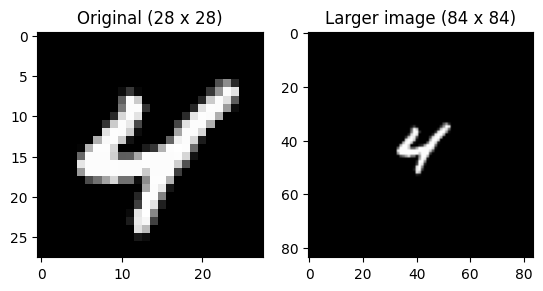

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Change to select another test image
i = 500
img = x_test[i,:] # Dimensions are [batch_size, channels, height, width]

# Pad with zeros to obtain image of size (28 + 2*padsize) = 84 if padsize = 28
padsize = 28
img_large = np.pad(img, ((0,0),(padsize,padsize),(padsize,padsize)))

#Print shapes
print('Original shape',img.shape)
print('Larger image shape',img_large.shape)

# Display
plt.subplot(1,2,1); plt.imshow(img.squeeze(),cmap='gray'); plt.title('Original (28 x 28)');
plt.subplot(1,2,2); plt.imshow(img_large.squeeze(),cmap='gray'); plt.title('Larger image (84 x 84)');

### Run sliding window
We should be able to detect the digit in the larger image (`img_large`) by running our current CNN model over the image in a sliding window fashion.
The input image is 84 x 84 pixels, and the network accepts images of shape 28x28. With a stride of 1, how many times can we run the network over the input image along each spatial dimension? Call this number `N`, insert it in the code block below, and run it.

Please ask me (Mads) if the task is unclear, or if you get stuck.

**Note** that it will take a while to run the code block below - that's the whole point :-)

Elapsed time 1.9495964050292969


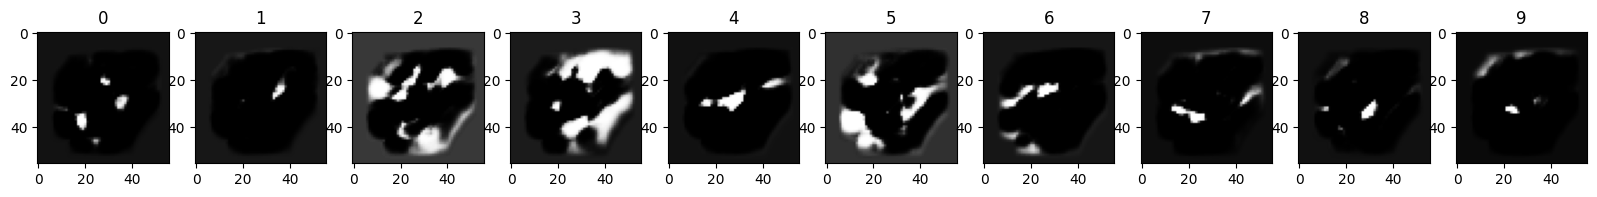

In [ ]:
import time

# Initialize result array
N = 56

result = np.zeros((N,N,num_classes))
net.eval()
# Perform sliding window
start = time.time()
for x in range(N):
  for y in range(N):
    cropout = img_large[:,x:x+28,y:y+28]
    output = net(torch.tensor(cropout).unsqueeze(0))
    result[x,y,:] = output.detach().numpy()

elapsed = time.time() - start
print('Elapsed time',elapsed)

# Show result
plt.figure(figsize=(20,6))
for c in range(num_classes):
  plt.subplot(1,num_classes,c+1)
  plt.imshow(result[:,:,c],vmin=0.,vmax=1.,cmap='gray')
  plt.title(str(c))

### Questions

1. What are we looking at here? That is, explain what the output images (result) show.
1. How long time did it take to run sliding window this way?



## Voting the outputs
The figure below shows the argmax (i.e., the index of the most likely class) for each spatial location. Note that the most likely class differs for different window positions. We can combine information from all spatial positions by counting the number of votes each class got.
Also Note that since we use softmax we forces the output to sum to 1, even though the classifier is unsure (e.g., in dark areas). Moreover, big digits are more likely to be covered and will therefore be detected at more positions.

0 got 57 votes
1 got 19 votes
2 got 1716 votes
3 got 562 votes
4 got 93 votes
5 got 388 votes
6 got 121 votes
7 got 74 votes
8 got 36 votes
9 got 70 votes


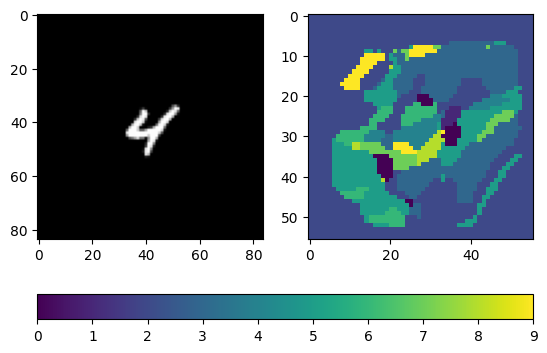

In [ ]:
fig, axs = plt.subplots(1,2);
axs
images = []
images.append(axs[0].imshow(img_large.squeeze(), cmap='gray'))
images.append(axs[1].imshow(np.argmax(result,axis=2),vmin=0,vmax=9))
fig.colorbar(images[1], ax=axs, orientation='horizontal', fraction=.1)

# Class with most "votes"
class_map = np.argmax(result,axis=2)
for digit in range(10):
  ix = np.where(class_map==digit)[0]
  votes = len(ix)
  print(str(digit) + ' got ' + str(votes) + ' votes')



## 4. Task 2: Efficient sliding window with FCN
Sliding window as implemented can take several seconds, even for this tiny image. To make the sliding window operation more efficient, we can convert our model to a fully convolutional network (FCN) by converting the fully connected layers to convolutional layers.

In summary, the procedure involves the following steps:

1. First set up an FCN equivalent to the CNN that we used above.
2. Train the FCN on the 28 x 28 training images (`x_train`).
3. Modify the FCN architecture such that it takes input images of arbitrary input shape (and test it on the 84 x 84 image).

The latter is a two-step procedure, where we first modify the FCN architecture a little bit (by removing a flatten layer), then copy the weights from the trained network.


### Step 1 - set up FCN
As a first step, convert our fully connected model into an FCN by replacing the fully connected layers with convolution layers. You can do this by filling in the missing code below (see comments to get help):


In [ ]:
num_classes = 10
channels = x_train.shape[1]
height = x_train.shape[2]
width = x_train.shape[3]


# define network

class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same')

        # Add three conv. layers that fulfill the requirements in the forward pass.


        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)


        # 1. At this point x has shape (N, 32, 7, 7)
        # 1.a add relu

        # 2. At this point x has shape (N, 64, 1, 1)
        # 2.a add relu

        # 3. At this point predictions has shape (N, num_classes, 1, 1)



        predictions = self.softmax(x) # softmax is changed to work along channel dimension
        return predictions


fcn = FCN()
print(fcn)

FCN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax(dim=1)
)


### Step 2 - train FCN
Unfortunately, it is not so straight forward to transfer the learned weights from the existing CNN (`model`) to the FCN (`fcn`). So we need to quickly train it:

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcn.parameters(), lr=0.1)
#optimizer = optim.Adam(net.parameters(), lr=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5) # decrease LR every two steps

nEpocs = 30 # How many times should we run over the data set?
totaliter = 0
fcn.train()
for epoch in range(nEpocs):  # loop over the dataset multiple times
    #print('epoch',epoch)
    running_loss = 0.0

    #scheduler.step()

    for i, data in enumerate(trainloader, 0):
        totaliter+=1

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = fcn(inputs)
        outputs_reshape = outputs.view(outputs.shape[0],-1)

        loss = criterion(outputs_reshape, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()


    print('Epoch %d, Train loss: %.3f' %(epoch + 1, running_loss / 100))

    running_loss = 0.0
print('Finished Training')
fcn.eval()

Epoch 1, Train loss: 7.675
Epoch 2, Train loss: 7.153
Epoch 3, Train loss: 7.152
Epoch 4, Train loss: 7.151
Epoch 5, Train loss: 7.151
Epoch 6, Train loss: 7.151
Epoch 7, Train loss: 7.151
Epoch 8, Train loss: 7.151
Epoch 9, Train loss: 7.151
Epoch 10, Train loss: 7.151
Epoch 11, Train loss: 7.151
Epoch 12, Train loss: 7.151
Epoch 13, Train loss: 7.151
Epoch 14, Train loss: 7.150
Epoch 15, Train loss: 7.150
Epoch 16, Train loss: 7.150
Epoch 17, Train loss: 7.150
Epoch 18, Train loss: 7.150
Epoch 19, Train loss: 7.150
Epoch 20, Train loss: 7.150
Epoch 21, Train loss: 7.150
Epoch 22, Train loss: 7.150
Epoch 23, Train loss: 7.150
Epoch 24, Train loss: 7.150
Epoch 25, Train loss: 7.150
Epoch 26, Train loss: 7.150
Epoch 27, Train loss: 7.150
Epoch 28, Train loss: 7.150
Epoch 29, Train loss: 7.150
Epoch 30, Train loss: 7.150
Finished Training


FCN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax(dim=1)
)

#### Question
1. Why is the `outputs.view` operation required during training, but not during test?
1. Is there any sliding window going on here (when running `fcn`)?


### Test speed (FCN vs simple slinding window)

Finally, let's verify that `fcn` performs sliding window much faster than the simple sliding window above by processing the 84 x 84 image, `img_large`:

In [ ]:
start = time.time()
result_large = fcn(torch.tensor(img_large).unsqueeze(0))
elapsed = time.time() - start
print(result_large.shape)
print(elapsed)

torch.Size([1, 16, 21, 21])
0.0022580623626708984


Display the results:

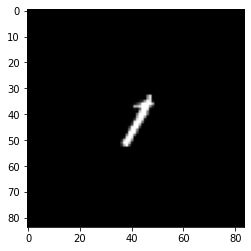

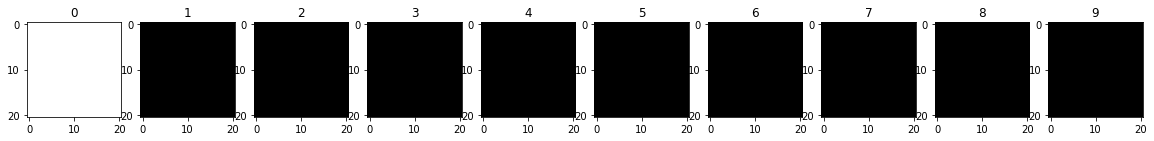

In [ ]:
# Show input image
plt.figure()
plt.imshow(img_large.squeeze(),cmap='gray')

#print(np.max(result_large.detach().numpy()[:,c,:,:]))

# Show result
plt.figure(figsize=(20,6))
for c in range(num_classes):
  plt.subplot(1,num_classes,c+1)
  plt.imshow(result_large.detach().numpy()[:,c,:,:].squeeze(),vmin=0.,vmax=1,cmap='gray')
  plt.title(str(c))

### Questions:
1. With simple sliding window, the output shape of `results` was NxNx10 = 57x57x10. However, when using FCN for sliding window, the output shape is 15x15x10. Why?

# Style transfer

Chapter 14.12 in [Dive into Deep Learning](https://d2l.ai/d2l-en.pdf) Shows how Neural Style Transfer can be implemented in PyTorch. Try implementing it on your own images. Try changing the weight of the style loss and the content loss. How does that affect the synthetic image?
The code samples uses a library called d2l, which is available from here: https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py